npzにclassification用のデータを書き出す。

In [1]:
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata

from pathlib import Path
from typing import List

from albumentations.pytorch.transforms import ToTensorV2
from catalyst.core import Callback, CallbackOrder, IRunner
from catalyst.dl import SupervisedRunner
from logger import WandbLogger
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

IMAGE_DIR = Path("train_images/")
savedir = Path("train_images_9_classification_all_nobox")
os.makedirs(savedir, exist_ok=True)

In [2]:
class HeadClassificationDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: Path, img_size=128, transforms=None):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        sample = self.df.loc[idx, :]
        x, y, w, h, video = sample.x, sample.y, sample.w, sample.h, sample.video
        image_id = sample.image_name
        frame_idx = int(image_id.split('.')[0].split('_')[-1])
        boxes_inframe = self.df[(self.df["frame"]==frame_idx)*(self.df["video"]==video)][['x', 'y', 'w', 'h',]].values
        prefix = '_'.join(image_id.split('.')[0].split('_')[:-1])
        try:    
            all_images = []
            for frame_diff in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #for box in boxes_inframe:
                #    cv2.rectangle(image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 0, 0))
                #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255))
                all_images.append(image)
        except:
            all_images = []
            for frame_diff in [-0, -0, -0, -0, 0,0, 0, 0, 0]:
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0))
                all_images.append(image)
        all_images = np.concatenate(all_images, axis=2)
        woffset = (self.img_size - w) // 2
        hoffset = (self.img_size - h) // 2
        
        left = max(x - woffset, 0)
        right = min(left + self.img_size, all_images.shape[1])
        
        top = max(y - hoffset, 0)
        bottom = min(top + self.img_size, all_images.shape[0])
        
        cropped = all_images[top:bottom, left:right].astype(np.uint8)
        
        # save img
        record = self.df.loc[idx, :]
        img_id = record.image_name[:-4]+"_"+str(record.x)+"_"+str(record.y)+"_"+str(record.w)+"_"+str(record.h)
        np.savez_compressed(os.path.join(savedir, img_id), cropped)
        return cropped

In [3]:
video_labels = pd.read_csv("train_labels_all.csv").fillna(0)
video_labels = video_labels[video_labels["frame"]>0]
video_labels.reset_index(inplace=True, drop=True)
trn_dataset = HeadClassificationDataset(video_labels, image_dir=IMAGE_DIR, img_size=128,)
trn_loader = torchdata.DataLoader(trn_dataset, batch_size=1, shuffle=False, num_workers=8)
video_labels.head()

Unnamed: 0  gameKey  playID     view                     video  frame  \
0           0    57583      82  Endzone  57583_000082_Endzone.mp4      1   
1           1    57583      82  Endzone  57583_000082_Endzone.mp4      1   
2           2    57583      82  Endzone  57583_000082_Endzone.mp4      1   
3           3    57583      82  Endzone  57583_000082_Endzone.mp4      1   
4           4    57583      82  Endzone  57583_000082_Endzone.mp4      1   

  label  left  width  top  height  impact impactType  confidence  visibility  \
0   H30   629     19   40      24       1          0         0.0         0.0   
1   V72   443     22  344      16       1          0         0.0         0.0   
2   V86   871     21  359      17       1          0         0.0         0.0   
3   V74   771     19  345      15       1          0         0.0         0.0   
4   V34   549     26  461      20       1          0         0.0         0.0   

                     image_name    x    y   w   h  
0  57583_000082_Endzone_001.png  629   40  19  24  
1  57583_000082_Endzone_001.png  443  344  22  16  
2  57583_000082_Endzone_001.png  871  359  21  17  
3  57583_000082_Endzone_001.png  771  345  19  15  
4  57583_000082_Endzone_001.png  549  461  26  20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

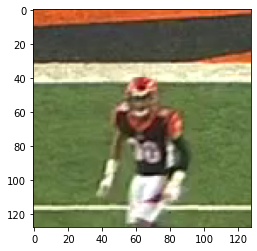

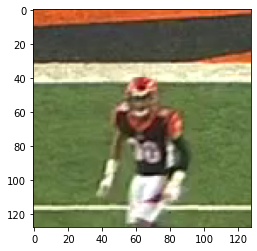

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


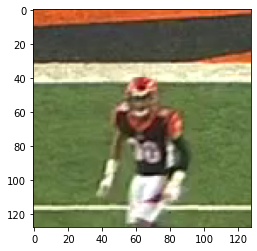

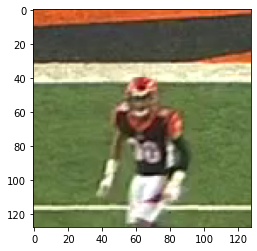

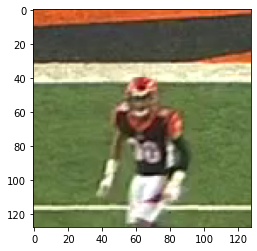

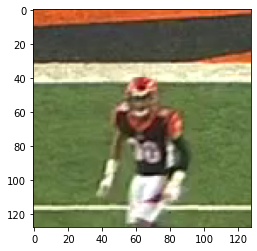

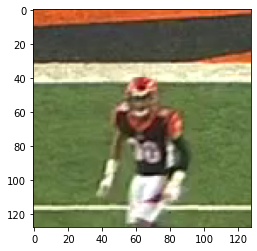

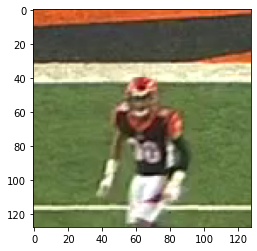

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


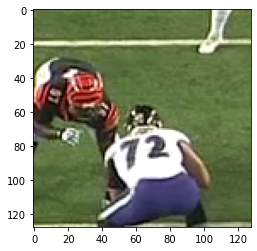

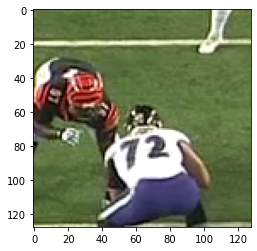

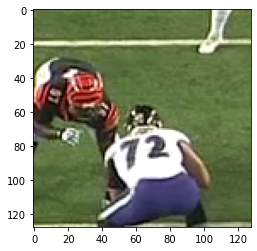

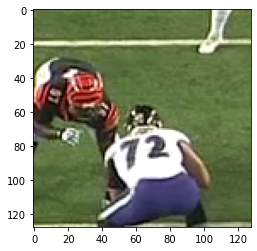

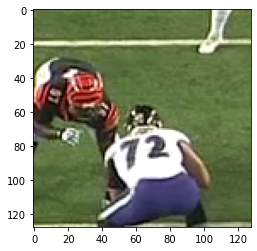

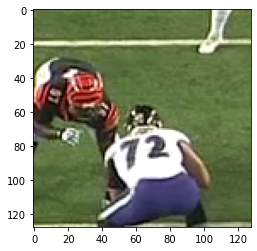

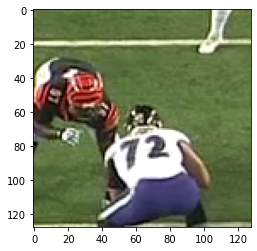

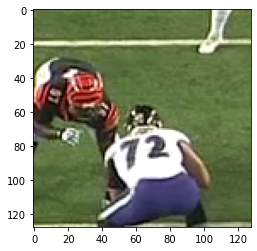

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


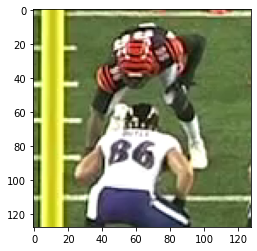

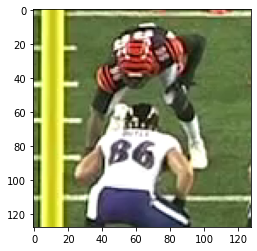

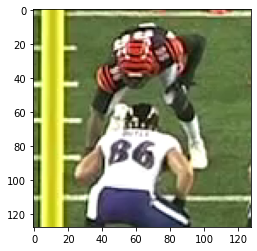

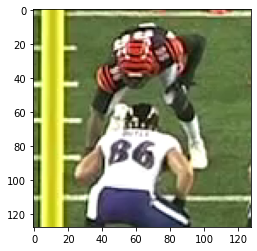

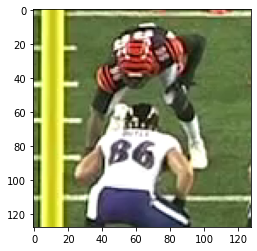

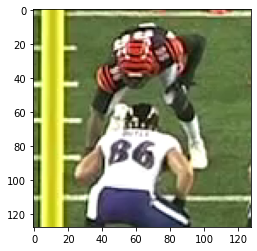

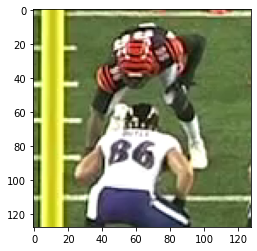

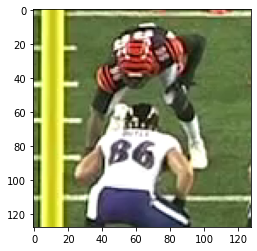

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


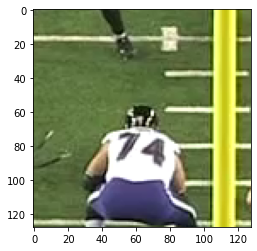

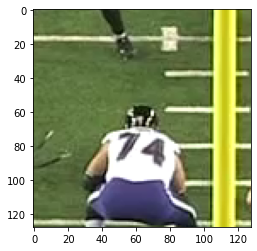

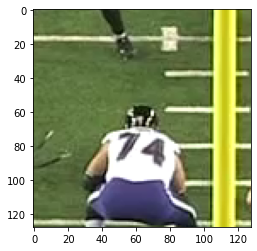

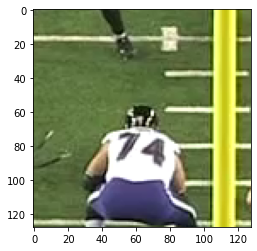

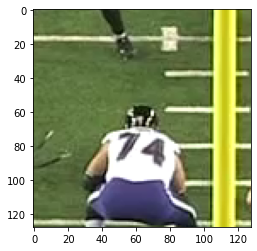

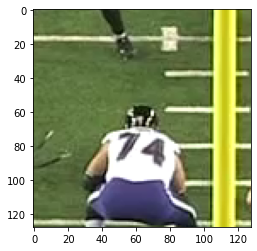

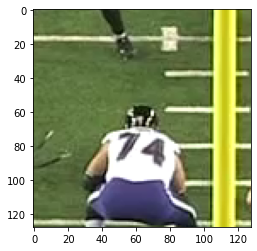

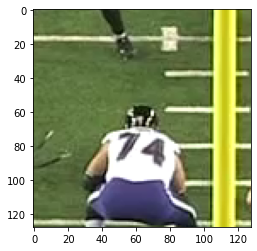

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


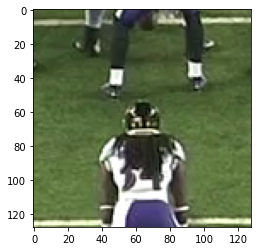

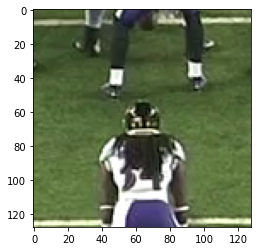

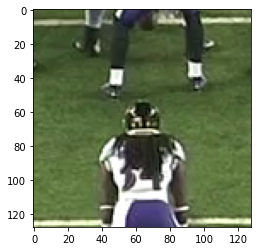

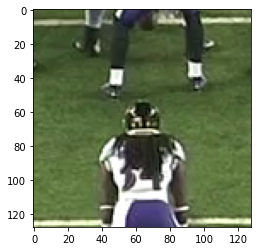

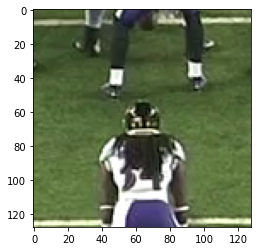

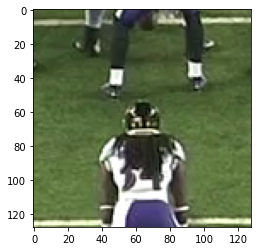

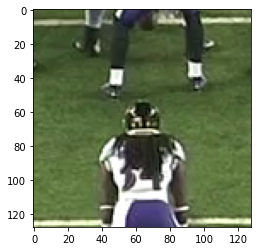

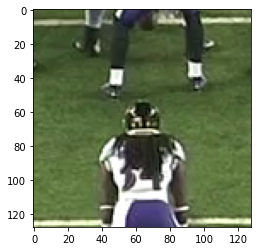

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


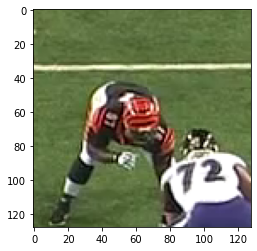

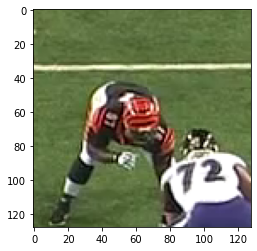

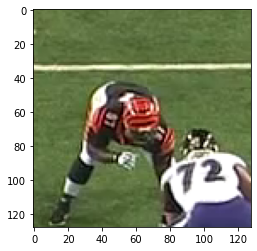

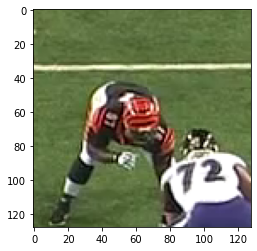

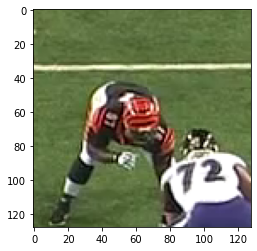

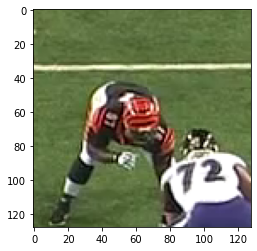

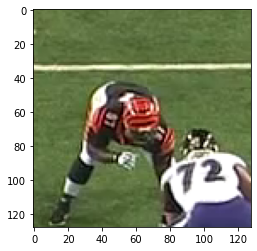

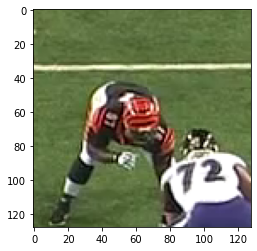

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


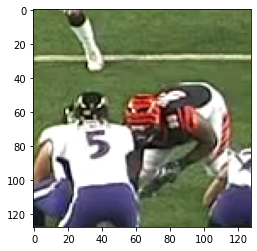

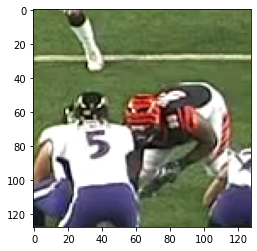

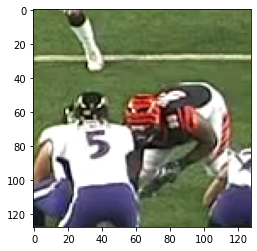

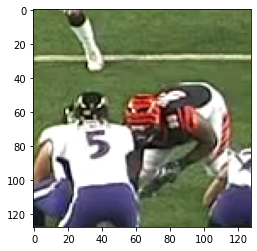

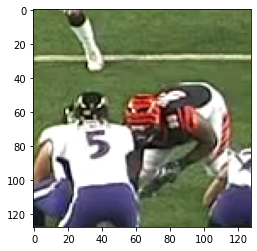

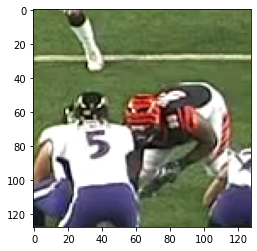

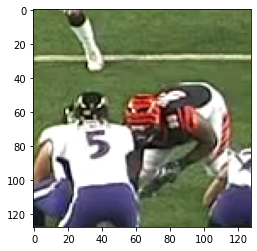

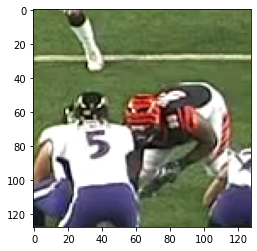

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


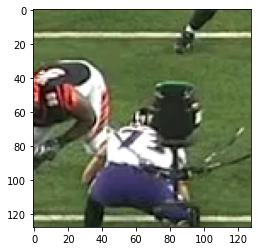

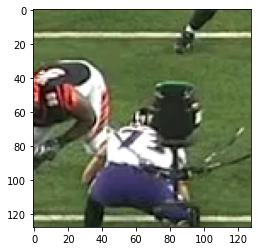

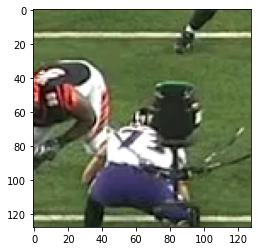

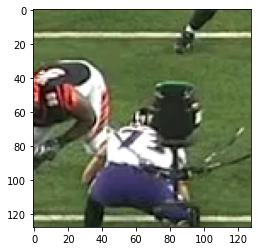

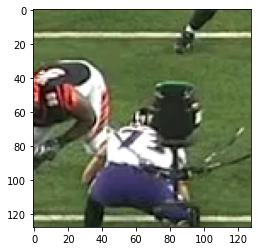

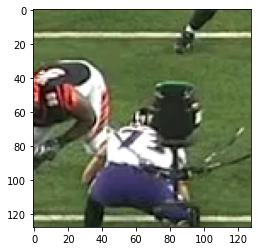

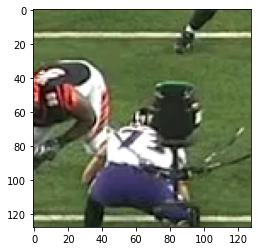

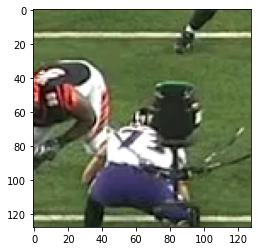

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


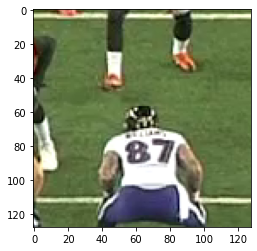

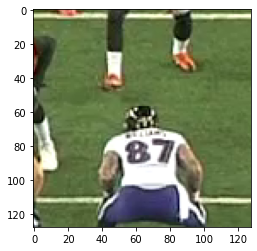

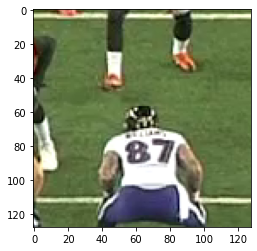

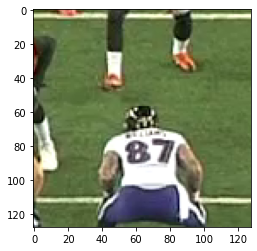

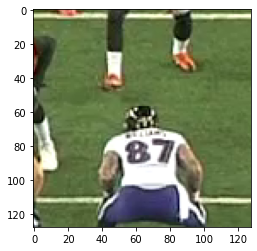

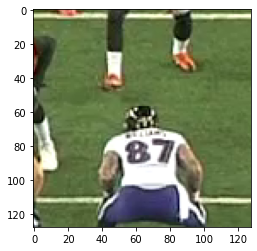

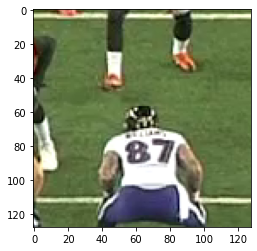

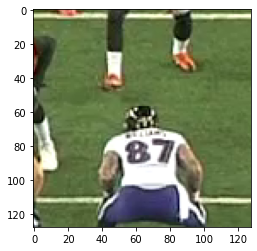

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


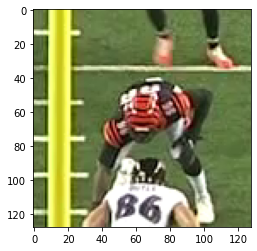

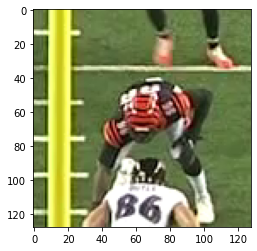

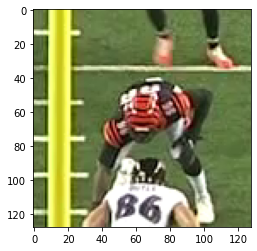

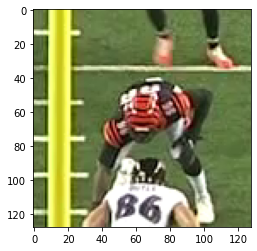

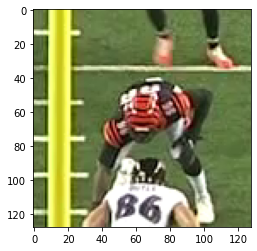

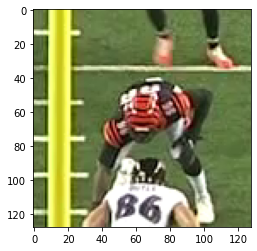

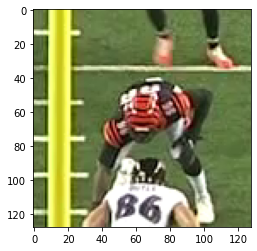

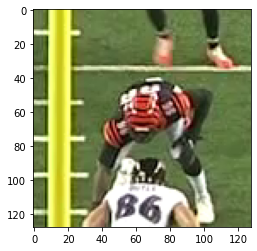

In [4]:
i = 0
for img in tqdm(trn_loader):
    for idx in range(8):
        plt.imshow(img[0][:,:,idx*3:idx*3+3])
        plt.show()
    i += 1
    if i == 10:
        break

In [ ]:
for img in tqdm(trn_loader):
    pass

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:20

In [ ]:
video_labels = pd.read_csv("train_labels_3.csv").fillna(0)
video_labels = video_labels[video_labels["frame"]>0]
video_labels.reset_index(inplace=True, drop=True)
trn_dataset = HeadClassificationDataset(video_labels, image_dir=IMAGE_DIR, img_size=128,)
trn_loader = torchdata.DataLoader(trn_dataset, batch_size=1, shuffle=False, num_workers=8)
video_labels.head()

for img in tqdm(trn_loader):
    pass

savedir = Path("train_images_9_classification_nobox")
os.makedirs(savedir, exist_ok=True)

class HeadClassificationDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: Path, img_size=128, transforms=None):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        sample = self.df.loc[idx, :]
        x, y, w, h = sample.x, sample.y, sample.w, sample.h
        image_id = sample.image_name
        frame_idx = int(image_id.split('.')[0].split('_')[-1])
        prefix = '_'.join(image_id.split('.')[0].split('_')[:-1])
        try:    
            all_images = []
            for frame_diff in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0))
                all_images.append(image)
        except:
            all_images = []
            for frame_diff in [-0, -0, -0, -0, 0,0, 0, 0, 0]:
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0))
                all_images.append(image)
        all_images = np.concatenate(all_images, axis=2)
        woffset = (self.img_size - w) // 2
        hoffset = (self.img_size - h) // 2
        
        left = max(x - woffset, 0)
        right = min(left + self.img_size, all_images.shape[1])
        
        top = max(y - hoffset, 0)
        bottom = min(top + self.img_size, all_images.shape[0])
        
        cropped = all_images[top:bottom, left:right].astype(np.uint8)
        
        # save img
        record = self.df.loc[idx, :]
        img_id = record.image_name[:-4]+"_"+str(record.x)+"_"+str(record.y)+"_"+str(record.w)+"_"+str(record.h)
        np.savez_compressed(os.path.join(savedir, img_id), cropped)
        return cropped

video_labels = pd.read_csv("train_labels_4.csv").fillna(0)
trn_dataset = HeadClassificationDataset(video_labels, image_dir=IMAGE_DIR, img_size=128,)
trn_loader = torchdata.DataLoader(trn_dataset, batch_size=1, shuffle=False, num_workers=8)
video_labels.head()

i = 0
for img in tqdm(trn_loader):
    pass